# AI EXPERT 1장 과제

이승관 브랜치 연습

원본출처: https://github.com/wikibook/rlnn

## 아래 코드를 실행해 보면서, 실행 결과와 각각에 대해서 적혀있는 질문의 대답에 대해서 PPT를 만들어 보세요.
.
## 질문은 언제나 카톡 으로 환영합니다.


### 다음과 같은 패키지를 설치해야 합니다
- numpy
- matplotlib

### conda를 사용한다면 설치방법
- conda install numpy matplotlib

### pip 을 사용한다면 설치방법
- pip install numpy matplotlib


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

: 

### 그림그리는 함수

In [ ]:
def show_v_table_small(v_table, env):
    for i in range(env.reward.shape[0]):        
        print("+----------"*env.reward.shape[1])
        print("|", end="")
        for j in range(env.reward.shape[1]):
            print("{0:8.2f}  |".format(v_table[i,j]),end="")
        print()
    print("+----------"*env.reward.shape[1])

# V table 그리기    
def show_v_table(v_table, env):    
    for i in range(env.reward.shape[0]):        
        print("+-----------------"*env.reward.shape[1],end="")
        print("+")
        for k in range(3):
            print("|",end="")
            for j in range(env.reward.shape[1]):
                if k==0:
                    print("                 |",end="")
                if k==1:
                        print("   {0:8.2f}      |".format(v_table[i,j]),end="")
                if k==2:
                    print("                 |",end="")
            print()
    print("+-----------------"*env.reward.shape[1],end="")
    print("+")
    
# Q table 그리기
def show_q_table(q_table,env):
    for i in range(env.reward.shape[0]):
        print("+-----------------"*env.reward.shape[1],end="")
        print("+")
        for k in range(3):
            print("|",end="")
            for j in range(env.reward.shape[1]):
                if k==0:
                    print("{0:10.2f}       |".format(q_table[i,j,0]),end="")
                if k==1:
                    print("{0:6.2f}    {1:6.2f} |".format(q_table[i,j,3],q_table[i,j,1]),end="")
                if k==2:
                    print("{0:10.2f}       |".format(q_table[i,j,2]),end="")
            print()
    print("+-----------------"*env.reward.shape[1],end="")
    print("+")
    

# 정책 policy 화살표로 그리기
def show_q_table_arrow(q_table,env):
    q = q_table
    for i in range(env.reward.shape[0]):        
        print("+-----------------"*env.reward.shape[1],end="")
        print("+")
        for k in range(3):
            print("|",end="")
            for j in range(env.reward.shape[1]):
                if k==0:
                    if np.max(q[i,j,:]) == q[i,j,0]:
                        print("        ↑       |",end="")
                    else:
                        print("                 |",end="")
                if k==1:                    
                    if np.max(q[i,j,:]) == q[i,j,1] and np.max(q[i,j,:]) == q[i,j,3]:
                        print("      ←  →     |",end="")
                    elif np.max(q[i,j,:]) == q[i,j,1]:
                        print("          →     |",end="")
                    elif np.max(q[i,j,:]) == q[i,j,3]:
                        print("      ←         |",end="")
                    else:
                        print("                 |",end="")
                if k==2:
                    if np.max(q[i,j,:]) == q[i,j,2]:
                        print("        ↓       |",end="")
                    else:
                        print("                 |",end="")
            print()
    print("+-----------------"*env.reward.shape[1],end="")
    print("+")    
    
# 정책 policy 화살표로 그리기
def show_policy_small(policy,env):
    for i in range(env.reward.shape[0]):        
        print("+----------"*env.reward.shape[1],end="")
        print("+")
        print("|", end="")
        for j in range(env.reward.shape[1]):
            if env.reward_list1[i][j] == "road":
                if policy[i,j] == 0:
                    print("   ↑     |",end="")
                elif policy[i,j] == 1:
                    print("   →     |",end="")
                elif policy[i,j] == 2:
                    print("   ↓     |",end="")
                elif policy[i,j] == 3:
                    print("   ←     |",end="")
            else:
                print("          |",end="")
        print()
    print("+----------"*env.reward.shape[1],end="")
    print("+")
    
# 정책 policy 화살표로 그리기
def show_policy(policy,env):
    for i in range(env.reward.shape[0]):        
        print("+-----------------"*env.reward.shape[1],end="")
        print("+")
        for k in range(3):
            print("|",end="")
            for j in range(env.reward.shape[1]):
                if k==0:
                    print("                 |",end="")
                if k==1:
                    if policy[i,j] == 0:
                        print("      ↑         |",end="")
                    elif policy[i,j] == 1:
                        print("      →         |",end="")
                    elif policy[i,j] == 2:
                        print("      ↓         |",end="")
                    elif policy[i,j] == 3:
                        print("      ←         |",end="")
                if k==2:
                    print("                 |",end="")
            print()
    print("+-----------------"*env.reward.shape[1],end="")
    print("+")

### Agent 구현

In [3]:
class Agent():
    
    # 1. 행동에 따른 에이전트의 좌표 이동(위, 오른쪽, 아래, 왼쪽) 
    action = np.array([[-1,0],[0,1],[1,0],[0,-1]])
    
    # 2. 각 행동별 선택확률
    select_action_pr = np.array([0.25,0.25,0.25,0.25])
    
    # 3. 에이전트의 초기 위치 저장
    def __init__(self):
        self.pos = (0,0)
    
    # 4. 에이전트의 위치 저장
    def set_pos(self,position):
        self.pos = position
        return self.pos
    
    # 5. 에이전트의 위치 불러오기
    def get_pos(self):
        return self.pos

### Environment 구현

In [4]:
class Environment():
    
    # 1. 미로밖(절벽), 길, 목적지와 보상 설정
    cliff = -3
    road = -1
    goal = 1
    
    # 2. 목적지 좌표 설정
    goal_position = [1,1]
    
    # 3. 보상 리스트 숫자
    reward_list = [[road,road],
                   [road,goal]]
    
    # 4. 보상 리스트 문자
    reward_list1 = [["road","road"],
                    ["road","goal"]]
    
    # 5. 보상 리스트를 array로 설정
    def __init__(self):
        self.reward = np.asarray(self.reward_list)    

    # 6. 선택된 에이전트의 행동 결과 반환 (미로밖일 경우 이전 좌표로 다시 복귀)
    def move(self, agent, action):
        
        done = False
        
        # 6.1 행동에 따른 좌표 구하기
        new_pos = agent.pos + agent.action[action]
        
        # 6.2 현재좌표가 목적지 인지확인
        if self.reward_list1[agent.pos[0]][agent.pos[1]] == "goal":
            reward = self.goal
            observation = agent.set_pos(agent.pos)
            done = True
        # 6.3 이동 후 좌표가 미로 밖인 확인    
        elif self.reward_list1[agent.pos[0]][agent.pos[1]] == "cliff" or\
            new_pos[0] < 0 or new_pos[0] >= self.reward.shape[0] or new_pos[1] < 0 or new_pos[1] >= self.reward.shape[1]:
            reward = self.cliff
            observation = agent.set_pos(agent.pos)
            done = True
        # 6.4 이동 후 좌표가 길이라면
        else:
            observation = agent.set_pos(new_pos)
            reward = self.reward[observation[0],observation[1]]
            
        return observation, reward, done

### 재귀적으로 상태 가치함수를 계산하는 함수

In [5]:
# 상태 가치 계산
def state_value_function(env,agent,G,max_step,now_step):
    
    # 1. 감가율 설정
    gamma = 0.9
    
# 2. 현재 위치가 도착지점인지 확인
    if env.reward_list1[agent.pos[0]][agent.pos[1]] == "goal":
        return env.goal
    
# 3. 마지막 상태는 보상만 계산
    if (max_step == now_step):
        pos1 = agent.get_pos()
        
        # 3.1 가능한 모든 행동의 보상을 계산
        for i in range(len(agent.action)):
            agent.set_pos(pos1)
            observation, reward, done = env.move(agent,i)
            G += agent.select_action_pr[i] * reward
            
        return G
    
    # 4. 현재 상태의 보상을 계산한 후 다음 step으로 이동
    else:
        
        # 4.1현재 위치 저장
        pos1 = agent.get_pos()
        
        # 4.2 현재 위치에서 가능한 모든 행동을 조사한 후 이동
        for i in range(len(agent.action)):
            observation, reward, done = env.move(agent,i)      
            # 4.2.1 현재 상태에서 보상을 계산
            G += agent.select_action_pr[i] * reward

            # 4.2.2 이동 후 위치 확인 : 미로밖, 벽, 구멍인 경우 이동전 좌표로 다시 이동
            if done == True:
                if observation[0] < 0 or observation[0] >= env.reward.shape[0] or observation[1] < 0 or observation[1] >= env.reward.shape[1]:
                    agent.set_pos(pos1)

            # 4.2.3 다음 step을 계산
            next_v = state_value_function(env, agent, 0, max_step, now_step+1)
            G += agent.select_action_pr[i] * gamma * next_v

            # 4.2.4 현재 위치를 복구
            agent.set_pos(pos1)

        return G


### 미로의 각 상태의 상태가치함수를 구하는 함수

max_step_number = 0 total_time = 0.0(s)
+-----------------+-----------------+
|                 |                 |
|      -2.00      |      -1.50      |
|                 |                 |
+-----------------+-----------------+
|                 |                 |
|      -1.50      |       1.00      |
|                 |                 |
+-----------------+-----------------+
max_step_number = 1 total_time = 0.0(s)
+-----------------+-----------------+
|                 |                 |
|      -3.58      |      -2.40      |
|                 |                 |
+-----------------+-----------------+
|                 |                 |
|      -2.40      |       1.00      |
|                 |                 |
+-----------------+-----------------+
max_step_number = 2 total_time = 0.0(s)
+-----------------+-----------------+
|                 |                 |
|      -4.69      |      -3.16      |
|                 |                 |
+-----------------+-----------------+
|     

No handles with labels found to put in legend.


max_step_number = 9 total_time = 4.38(s)
+-----------------+-----------------+
|                 |                 |
|      -7.74      |      -5.32      |
|                 |                 |
+-----------------+-----------------+
|                 |                 |
|      -5.32      |       1.00      |
|                 |                 |
+-----------------+-----------------+


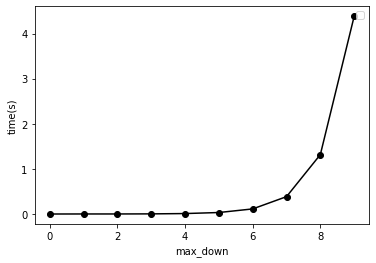

In [6]:
# 1. 환경 초기화
env = Environment()

# 2. 에이전트 초기화
agent = Agent()

# 3. 최대 max_step_number 제한
max_step_number = 10

# 4. 계산 시간 저장을 위한 list
time_len = []

# 5. 재귀함수 state_value_function을를 이용해 각 상태 가치를 계산
for max_step in range(max_step_number):
    
    # 5.1 미로 각 상태의 가치를 테이블 형식으로 저장
    v_table = np.zeros((env.reward.shape[0],env.reward.shape[1]))    
    start_time = time.time()
    
    # 5.2 미로의 각 상태에 대해 state_value_function() 을 이용해 가치를 계산한 후 테이블 형식으로 저장
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            agent.set_pos([i,j])
            v_table[i,j] = state_value_function(env,agent, 0, max_step, 0)
            
    # 5.3 max_down에 따른 계산시간 저장
    time_len.append(time.time()-start_time)
    print("max_step_number = {} total_time = {}(s)".format(max_step, np.round(time.time()-start_time,2)))
    
    show_v_table(np.round(v_table,2),env)

# 6. step 별 계산 시간 그래프 그리기    
plt.plot(time_len, 'o-k')
plt.xlabel('max_down')
plt.ylabel('time(s)')
plt.legend()
plt.show()

### 위 코드까지는 각 상태에서 최대 스텝 제한을 두어 벨만 방정식을 따른 상태 가치 함수의 근사값을 구하는 과정이다.

상태는 (0, 0), (0, 1), (1, 0), (1, 1)이 있다.

행동은 상, 하, 좌, 우 이동으로 각 확률은 25%로 균등하다.

보상은 road로 가는 행동은 -1, goal로 가는 행동은 1이며, 맵 바깥을 벗어나거나 절벽으로 가는 행동은 -3 이다.

맵 바깥을 벗어나거나 절벽으로 가면 행동하기 전 위치로 상태가 된다.


특정 상태에서의 벨만 방정식 상태 가치 함수를 구할 때는, (엄밀하게 정의하자면) 무한한 행동을 취했을 때의 보상의 총합의 기댓값이다. 실제로는 무한한 행동을 구현할 수는 없으므로, 이 코드에서는 max_step_number로 행동 횟수 제한을 두었다 (이 코드에서 max_step_number=0 이면 행동 1번만 고려한다는 의미이다).

max_step_number가 크면 클 수록 엄밀한 벨만방정식 상태 가치 함수에 가까워질 것이다.

### 질문 1-1. 위 코드 내용을 기반으로 상태는 (0, 0), (0, 1), (1, 0), (1, 1)에 대한 마르코프 체인 네트워크와 상태 전이 매트릭스를 그려보자. 옳게 그린다면, 상태 전이 매트릭스는 4x4 행렬이어야 한다

### 질문 1-2. (1.)에서 그린 상태 전이 매트릭스를 기반으로, max_step_number = 0일 때 (즉, 행동 한 번만 고려할 때) 상태 (0, 0), (0, 1), (1, 0)에서에 벨만 방정식 상태 가치 함수의 근사값을 수식으로 구하는 과정을 보여보자.

예: V(X=(0, 0)) = P_(0,0)(0,0) * R_(0,0) + P_(0,0)(0,1) * R_(0,1) + P_(0,0)(1,0) * R_(1,0) + P_(0,0)(1,1) * R_(1,1) 

= 0.5 * -3 + 0.25 * -1 + 0.25 * -1 + 0.0 * 1 = -2.00


### 재귀적으로 행동가치함수를 계산하는 함수

In [7]:
# 행동 가치 함수
def action_value_function(env, agent, act, G, max_step, now_step):   
    
    # 1. 감가율 설정
    gamma = 0.9
    
    # 2. 현재 위치가 목적지인지 확인
    if env.reward_list1[agent.pos[0]][agent.pos[1]] == "goal":
        return env.goal

    # 3. 마지막 상태는 보상만 계산
    if (max_step == now_step):
        observation, reward, done = env.move(agent, act)
        G += agent.select_action_pr[act]*reward
        return G
    
    # 4. 현재 상태의 보상을 계산한 후 다음 행동과 함께 다음 step으로 이동
    else:
        # 4.1현재 위치 저장
        pos1 = agent.get_pos()
        observation, reward, done = env.move(agent, act)
        G += reward
        
        # 4.2 이동 후 위치 확인 : 미로밖, 벽, 구멍인 경우 이동전 좌표로 다시 이동
        if done == True:            
            if observation[0] < 0 or observation[0] >= env.reward.shape[0] or observation[1] < 0 or observation[1] >= env.reward.shape[1]:
                agent.set_pos(pos1)
            
        # 4.3 현재 위치를 다시 저장
        pos1 = agent.get_pos()
        
        # 4.4 현재 위치에서 가능한 모든 행동을 선택한 후 이동
        for i in range(len(agent.action)):
            agent.set_pos(pos1)
            next_v = action_value_function(env, agent, i, 0, max_step, now_step+1)
            G += agent.select_action_pr[i] * gamma * next_v
        return G


In [8]:


# 1. 환경 초기화
env = Environment()

# 2. 에이전트 초기화
agent = Agent()
np.random.seed(0)

# 3. 계산 시간 저장을 위한 list
time_len = []

max_step_number = 10

for max_step in range(max_step_number):
    start_time = time.time()
    # 4.1 미로 상의 모든 상태에서 가능한 행동의 가치를 저장할 테이블을 정의
    #print("max_step = {}".format(max_step))
    q_table = np.zeros((env.reward.shape[0], env.reward.shape[1],len(agent.action)))
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            # 4.2 모든 행동에 대해
            for action in range(len(agent.action)):
                # 4.2.1 에이전트의 위치를 초기화
                agent.set_pos([i,j])
                # 4.2.2 현재 위치에서 행동 가치를 계산
                q_table[i ,j,action] = action_value_function(env, agent, action, 0, max_step, 0)
                
    time_len.append(time.time()-start_time)
    print("max_step_number = {} total_time = {}(s)".format(max_step, np.round(time.time()-start_time,2)))

    q = np.round(q_table,2)
    print("Q - table")
    show_q_table(q, env)
    print("High actions Arrow")
    show_q_table_arrow(q,env)
    print()


max_step_number = 0 total_time = 0.0(s)
Q - table
+-----------------+-----------------+
|     -0.75       |     -0.75       |
| -0.75     -0.25 | -0.25     -0.75 |
|     -0.25       |      0.25       |
+-----------------+-----------------+
|     -0.25       |      1.00       |
| -0.75      0.25 |  1.00      1.00 |
|     -0.75       |      1.00       |
+-----------------+-----------------+
High actions Arrow
+-----------------+-----------------+
|                 |                 |
|          →     |                 |
|        ↓       |        ↓       |
+-----------------+-----------------+
|                 |        ↑       |
|          →     |      ←  →     |
|                 |        ↓       |
+-----------------+-----------------+

max_step_number = 1 total_time = 0.0(s)
Q - table
+-----------------+-----------------+
|     -3.45       |     -3.34       |
| -3.45     -1.34 | -1.45     -3.34 |
|     -1.34       |      1.90       |
+-----------------+-----------------+
|     -1.45   

## 정책 평가를 통한 행동 가치 함수 구하기

In [9]:
def update_q_table_once(env, agent, q_table):   
    old_q_table = q_table
    old_v_table = np.zeros([env.reward.shape[0], env.reward.shape[1]])
    new_q_table = np.copy(q_table)
    # 1. 감가율 설정
    gamma = 0.9
    
    
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            if env.reward_list1[i][j] == "goal":
                old_v_table[i][j] = env.goal
            else:
                for action in range(len(agent.action)):
                    old_v_table[i][j] +=  agent.select_action_pr[action] * old_q_table[i][j][action]
    
    
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            for action in range(len(agent.action)):
                if env.reward_list1[i][j] == "goal":
                    new_q_table[i][j][action] = env.goal
                    continue
                agent.set_pos([i, j])
                observation, reward, done = env.move(agent, action)
                next_pos = agent.get_pos()
                new_q_table[i][j][action] = reward + gamma * old_v_table[next_pos[0], next_pos[1]]
    return new_q_table

  
env = Environment()

# 2. 에이전트 초기화
agent = Agent()
np.random.seed(0)

q_table = np.zeros((env.reward.shape[0], env.reward.shape[1],len(agent.action)))

for i in range(10):
  print("step {}".format(i))
  q_table = update_q_table_once(env, agent, q_table)
  
  show_q_table(np.round(q_table, 2), env)
  print("High actions Arrow")
  show_q_table_arrow(np.round(q_table, 2),env)

step 0
+-----------------+-----------------+
|     -3.00       |     -3.00       |
| -3.00     -1.00 | -1.00     -3.00 |
|     -1.00       |      1.90       |
+-----------------+-----------------+
|     -1.00       |      1.00       |
| -3.00      1.90 |  1.00      1.00 |
|     -3.00       |      1.00       |
+-----------------+-----------------+
High actions Arrow
+-----------------+-----------------+
|                 |                 |
|          →     |                 |
|        ↓       |        ↓       |
+-----------------+-----------------+
|                 |        ↑       |
|          →     |      ←  →     |
|                 |        ↓       |
+-----------------+-----------------+
step 1
+-----------------+-----------------+
|     -4.80       |     -4.15       |
| -4.80     -2.15 | -2.80     -4.15 |
|     -2.15       |      1.90       |
+-----------------+-----------------+
|     -2.80       |      1.00       |
| -4.15      1.90 |  1.00      1.00 |
|     -4.15       |      

### 위 코드까지는 각 (상태, 행동) 쌍에서 행동 가치 함수를 구하는 두 가지 과정이다.


### 질문 2-1. 재귀적으로 구하는 과정과 정책 평가로 구하는 두 과정을 비교해보자. 구하는 과정은 어떤 점에서 차이가 있는가? 두 행동 가치 함수 테이블은 가까워 지는가? 무엇이 더 좋은 방법이라고 생각하는가? 그 이유는 무엇인가?

### 질문 2-2. 왼쪽 상단, 즉 (0, 0)에서 에이전트가 출발한다고 생각해보자. 어떻게 행동을 취하면 Goal에 도착하는가? 가능한 행동의 리스트를 한 가지 경우만 제시해보자. 어떠한 기준으로 행동을 선택하였는가?


